In [1]:
sim = 2

In [2]:
from steering_sys import STEERING_SYSTEM
from controller import CONTROLLER,SMO
import numpy as np
from numpy import sign, sin,cos
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
# =============================================================================
#                               Define Values
# =============================================================================
black = [0,0,0];
orange = [.90,.60,.0];
skyBlue = [.35,.70,.90];
bluishGreen = [0,.60,.50];
yellow = [.95,.90,.25];
blue = [0,.45,.70];
vermilion = [.80,.40,0];
reddishPurple = [.80,.60,.70];

forceColor = vermilion;
dispColor = bluishGreen;
disturbColor = reddishPurple;

duration = 5
dt = 10**-3
h = 0.01
n = int(h/dt)
N = int(duration/dt)

mySteer = STEERING_SYSTEM(dt)
myController = CONTROLLER(dt,N)
myObs = SMO(dt)

def fault(x):
    if sim==1:
        return 1
    x *= 1000
    x = x%20

    return min(1,(x-14)**4+0.5)

def disturbance(t):
    a = 100
    M1 = sin(t**2) * (cos(3*t)+sin(5*t)+sin(7*t))
    M2 = sin(t**2) * (cos(10*t)+cos(4*t)+sin(6*t))
    return np.array([M1,M2])*a

def ref(t):
    f = np.pi*t/5
    a = 20*np.pi/180.0 /9.5
    x1 = a*np.sin(f*t)
    x2 = 2*a*f*np.cos(f*t)

    return np.array([[x1],[x2]])





In [3]:

History = np.zeros([N,13])
Time = np.zeros(N)
# =============================================================================
#                           Sim Loop
# =============================================================================
u=0
d_hat = 0
x = mySteer.get_delta_r()[:2]
for i in range(N):

    t = i*dt
    M = disturbance(t)
    mySteer.step_xdd(M,u*fault(x[0])) 
    x = mySteer.get_delta_r()[:2]
    tmp = myObs.step_obs(x,u)
    d_hat = d_hat*0.5 + 0.5*tmp
    
    err = ref(t) - x
    u = -myController.step_controller(err,0)
    u -= d_hat

    d_eq = (mySteer.xd*M[0] + mySteer.zd*M[1])/(x[1]+0.00000000000001*sign(x[1]))

    delays = myController.get_delays()
    History[i] = [x[0],ref(t)[0],x[1],ref(t)[1],u,delays[0],d_eq,0,0,delays[1],delays[2],delays[3],d_hat]
    Time[i] = t


C:\Users\Erfan\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Erfan\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


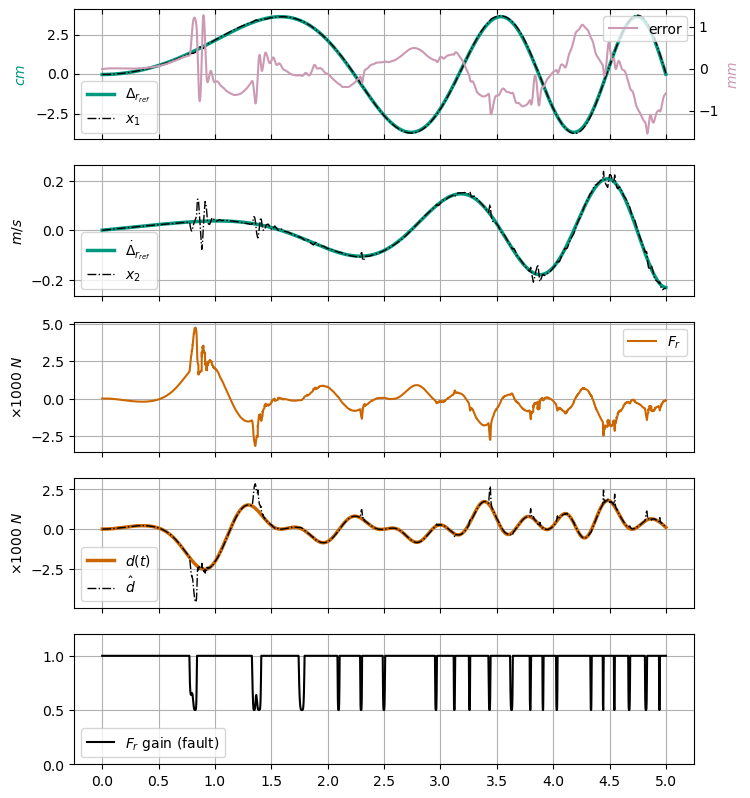

In [4]:
if sim==1:
    pn = 4
else:
    pn = 5

fig = plt.figure(num=None, figsize=(8, pn*2), dpi=100)
ticks_l = ['','','','','','','','','','','']
ticks =  np.arange(0, 5.5, 0.5).tolist()

host = host_subplot(pn,1,1, axes_class=AA.Axes)
# plt.subplots_adjust(right=1)


par2 = host.twinx()

offset = 0
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))
par2.axis["right"].toggle(all=True)
par2.set_ylabel("$mm$")

p1, =host.plot(Time , 100*History[:,1],label=r"${\Delta}_{r_{ref}}$",linewidth=2.5,color=dispColor)
host.plot(Time , 100*History[:,0],'-.',label='$x_1$',linewidth=1,color=black)
host.legend()
host.set_ylabel("$cm$")
host.set_xticks(ticks)
host.set_xticklabels(ticks_l)
host.grid()

p2, =par2.plot(Time, 1000*(History[:,1]-History[:,0]),label='error',color=reddishPurple )
par2.legend()
# par2.set_ylim(-3, 3)


host.axis["left"].label.set_color(p1.get_color())
par2.axis["right"].label.set_color(p2.get_color())


# plt.ylim(-10,10)

plt.subplot(pn,1,2)
plt.plot(Time , History[:,3],label=r"$\dot{\Delta}_{r_{ref}}$",linewidth=2.5,color=dispColor)
plt.plot(Time , History[:,2],'-.',label='$x_2$',linewidth=1,color=black)
plt.legend()
plt.ylabel('$m/s$')
plt.xticks(ticks,labels=ticks_l)
plt.grid(True)

plt.subplot(pn,1,3)
plt.plot(Time , History[:,4]/1000,label='$F_r$',linewidth=1.5,color=forceColor)
plt.legend()
plt.ylabel(r'$\times1000 \ N$')
plt.xticks(ticks,labels=ticks_l)
plt.grid()

plt.subplot(pn,1,4)
plt.plot(Time , History[:,6]/1000,label=r'$d(t)$',linewidth=2.5,color=forceColor)
plt.plot(Time , History[:,12]/1000,'-.',label=r"$\^d$",linewidth=1,color=black)
plt.legend()
plt.ylabel(r"$\times1000 \ N$")
if sim==1:
    plt.xticks(ticks)
else:
    plt.xticks(ticks,labels=ticks_l)
plt.grid()

y = np.zeros_like(History[:,0])
for i,x in enumerate(History[:,0]):
    y[i] = fault(x)

if sim == 2:
    plt.subplot(pn,1,5)
    plt.plot(Time , y,'k',label='$F_r$ gain (fault)')
    plt.xticks(ticks)
    plt.legend()
    plt.grid()
    plt.ylim([0,1.2])

plt.draw()
plt.savefig('sim%d.svg'%sim)
plt.show()

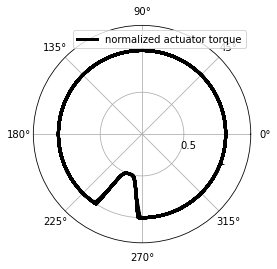

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(2*np.pi*History[:,0]/0.02, y,'k',label='normalized actuator torque',linewidth=3)
ax.set_rmax(1.3)
ax.set_yticks([0.5, 1])  # Less radial ticks
ax.set_yticklabels(['0.5','1'])
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.legend()
# ax.set_title("A line plot on a polar axis", va='bottom')
plt.savefig('sim%d_actuator_torque.svg'%sim)
plt.show()

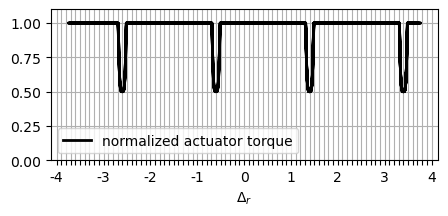

In [6]:
ticks = np.arange(-4, 4.1, 1/10).tolist()
ticks_l =[]
for x in ticks:
    if x%1.0 < 0.001:
        ticks_l.append('%d'%np.round(x))
    else:
        ticks_l.append(' ')
        
fig = plt.figure(num=None, figsize=(5, 2), dpi=100)
plt.plot(100*History[:,0], y,'k',label='normalized actuator torque',linewidth=2)
plt.ylim([0,1.1])
plt.xticks(ticks,ticks_l)
plt.xlabel(r"$\Delta_{r}$")
plt.grid()
plt.legend()
plt.savefig('sim%d_actuator_torque_2.svg'%sim)
plt.show()

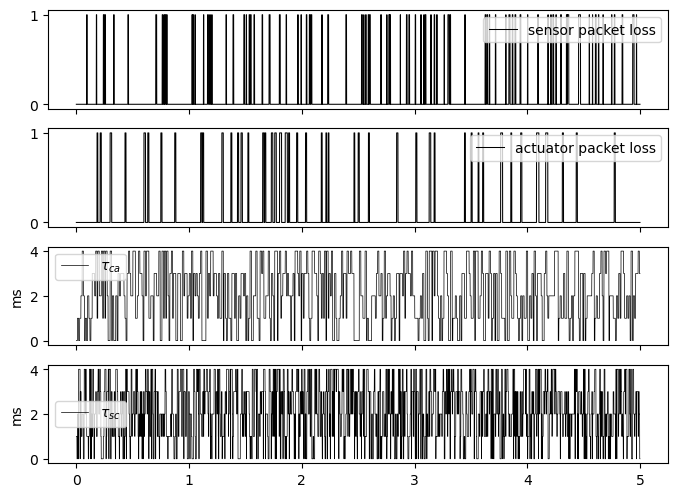

In [7]:

fig = plt.figure(num=None, figsize=(8, 6), dpi=100)

(ax1, ax2, ax3, ax4,) = fig.subplots(4, sharex=True)

ax1.plot(Time , History[:,10],'k',label='sensor packet loss',linewidth=.75)
ax1.legend()
ax1.set_yticks([0,1])

ax2.plot(Time , History[:,11],'k',label='actuator packet loss',linewidth=.75)
ax2.legend()
ax2.set_yticks([0,1])

ax3.plot(Time , 1000*h*History[:,9]/n,'k',label=r"$\tau_{ca}$",linewidth=.5)
ax3.legend()
ax3.set_ylabel('ms')

ax4.plot(Time , 1000*h*History[:,5]/n,'k',label=r"$\tau_{sc}$",linewidth=.5)
ax4.legend()
ax4.set_ylabel('ms')

fig.savefig('sim_delays.svg')
